[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luleu96/GenAIinDD_Exercises/blob/work/Exercises/Exercise_2/molGA.ipynb)

In [1]:
!git clone https://github.com/luleu96/GenAIinDD_Exercises.git
%cd /content/GenAIinDD_Exercises

fatal: destination path 'GenAIinDD_Exercises' already exists and is not an empty directory.
/content/GenAIinDD_Exercises


In [2]:
!pip install rdkit
!pip install mol_ga
!pip install molfeat

In [3]:
import joblib
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem import Draw
import pickle as pkl
import joblib
from molfeat.trans.fp import FPVecTransformer

from mol_ga import mol_libraries, default_ga

In [4]:
import os
working_dir = os.getcwd()

In [29]:
def run_molGA(f_opt):
    # starting molecules: we choose random molecules from ZINC
    start_smiles = mol_libraries.random_zinc(1000)

    # Run GA with fast parallel generation
    with joblib.Parallel(n_jobs=-1) as parallel:
        ga_results = default_ga(
            starting_population_smiles=start_smiles,
            scoring_function=f_opt,
            max_generations=30,
            offspring_size=100,
            parallel=parallel,
        )
    return ga_results

In [27]:
# optimization function: QED ~ 1 min
#
f_opt = lambda s_list: [QED.qed(Chem.MolFromSmiles(s)) for s in s_list]

ga_results = run_molGA(f_opt)

# Print the best molecule
print(max(ga_results.population))


(0.9481389265490767, 'Cn1cccc1C1=CO[C@@H](C(=O)Nc2ccc(F)c(F)c2)O1')


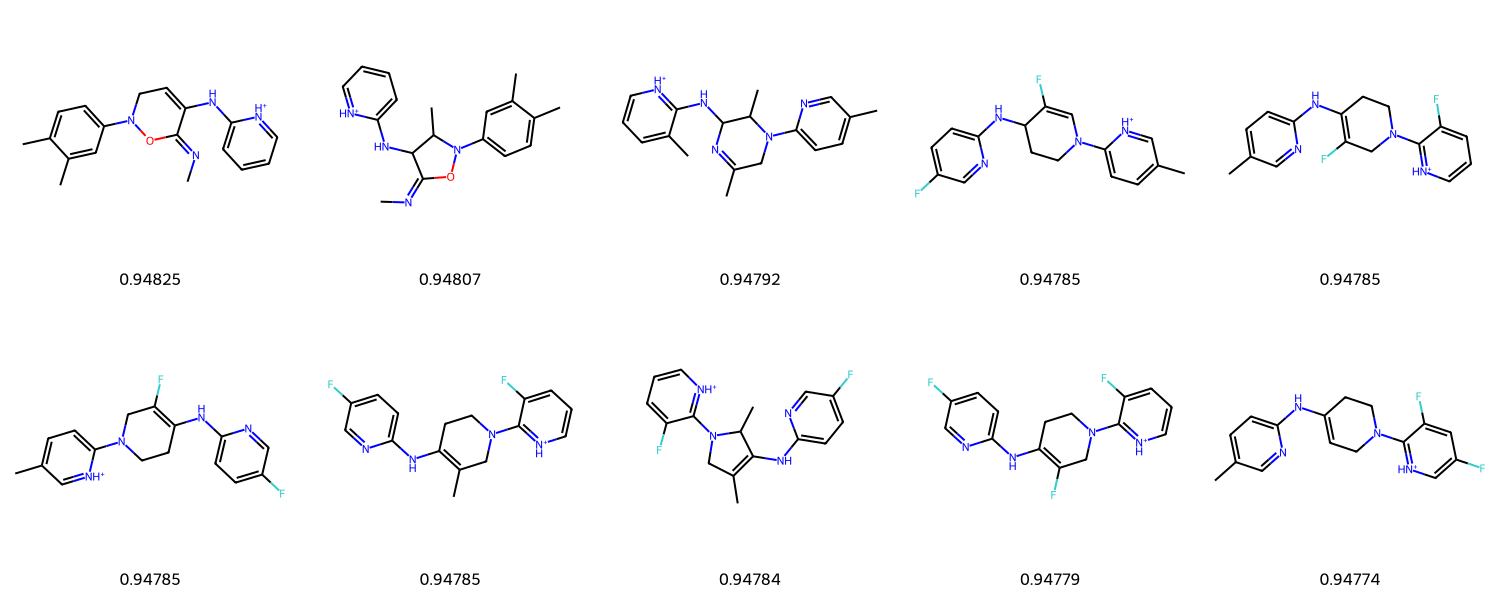

In [7]:
top_n_molecs = [Chem.MolFromSmiles(smiles[1]) for smiles in list(sorted(ga_results.population,reverse=True)[:10])]
top_n_scores = [str(round(smiles[0],5)) for smiles in list(sorted(ga_results.population,reverse=True)[:10])]

img = Draw.MolsToGridImage(top_n_molecs, molsPerRow=5, subImgSize=(300, 300), legends=top_n_scores)
img

In [8]:
# transform smiles into fingerprints for rf model
fp_transformer = FPVecTransformer(kind="ecfp:4", length=2048)
features = fp_transformer(mol_libraries.random_zinc(1000))

In [9]:
with open(os.path.join(working_dir, "Models", "rf_regressor.pkl"), "rb") as fin:
    fp_trans, loaded_RF_model = pkl.load(fin)

In [10]:
transformed_new_data = fp_trans.transform([smiles[1] for smiles in sorted(ga_results.population,reverse=True)])

In [11]:
mol_libraries.random_zinc(1000)[1]

'OCCN(c1nc(Br)cn2ccnc12)C1CCCC1'

In [12]:
predictions = loaded_RF_model.predict(transformed_new_data)
len(predictions)

8102

In [13]:
top_n_rf_scores = [str(round(x,4)) for x in list(predictions[:10])]

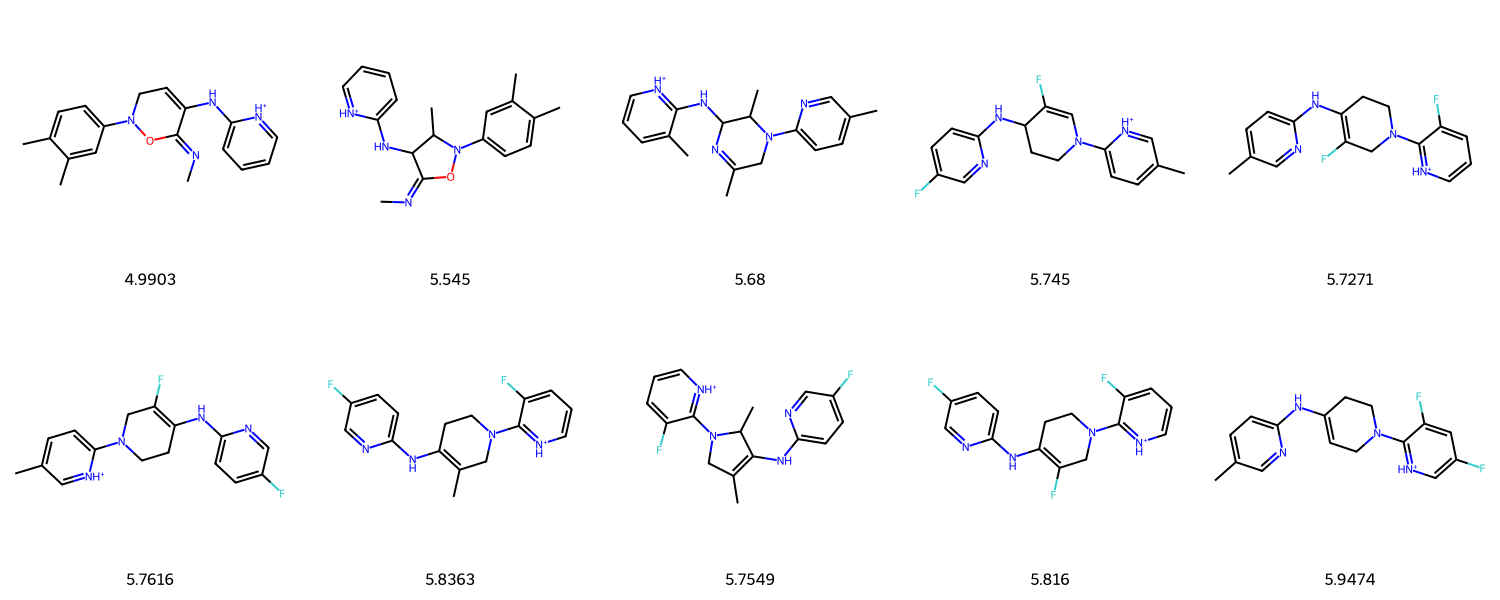

In [14]:
# rf model score of the top n candidates of the first molga run
img = Draw.MolsToGridImage(top_n_molecs, molsPerRow=5, subImgSize=(300, 300), legends=top_n_rf_scores)
img

In [30]:
# optimization function: RF regressor
# if this takes to long, reduce max_generations in runmolGA
# ~4 min for 30 max_generations, more than that takes too long
f_opt2 = lambda s_list: [loaded_RF_model.predict(fp_trans.transform(Chem.MolFromSmiles(s)))[0] for s in s_list]
ga_results = run_molGA(f_opt2)

# Print the best molecule
print(max(ga_results.population))

(8.852159999999998, 'C=C=NCn1c2c(c3sc(C4=CC([C@@H]5C(C6C(N[O-])=CC[C@H]6NC(=O)CN6CCc7c(n(CC=C)c8cc(-c9cc(NC(=O)C=C)ccn9)sc78)C6=O)=CCC[C@H]5NC(=O)N5C(=O)C5NC(=O)Cn5ncc6c7sc(C8C(NC(=O)C=C)CC8C(=O)[O-])cc7n(C7C=CN=C7N=C)c6c5=O)C=N4)cc31)CCN(CC(=O)N[C@@H]1CC=C(NC3CN(CC(=O)NC4CC(C(=O)n5c6cc(C7C(NC(=O)C=C)CC7C(=O)[O-])sc6c6cnn(CC(=O)Cn7c8cc(C9C(NC(=O)Cn%10ncc%11c%12sc(C%13C(NC(=O)C=C)CC%13NC(=O)C=C)cc%12n(CC(N=C)=NC=C)c%11c%10=O)CC9C(=O)[O-])sc8c8cnn(CC(=O)N[C@@H]9CCC=C(C%10C(NC(=O)C=C)=CC[C@H]%10NC(=O)CN%10CCc%11c(n(CC=C)c%12cc(-c%13cc(NC(=O)C=C)ccn%13)sc%11%12)C%10=O)[C@H]9NC(=O)C=C)c(=O)c87)c(=O)c65)C4c4cc5c(s4)c4cnn(C6C(NC(=O)C=C)=CC[C@H]6NC(=O)CN[CH]C6c7sc(C8C(NC(=O)n9ncc%10c%11c(n(CC=C)c%10c9=O)C=[SH]C(NC(=O)C=C)S%11)CC8C(=O)C=C)cc7N6Cc6ncccn6)c(=O)c4n5Cc4ncccn4)NC3c3cc4c(s3)c3cnn(CC(=O)N[C@@H]5CCC=C(C6C(NC(=O)C=C)=CC[C@H]6NC(=O)CN6CCc7c(n(CC=C)c8cc(-c9cc(NC(=O)C=C)ccn9)sc78)C6=O)[C@H]5C5=CCC[C@@H](NC(=O)CC(=O)C=C)[C@@H]5c5ncccn5)c(=O)c3n4Cc3ncccn3)C1C1=CCC[C@@H](NC(=O)Cn3ncc4c5sc(C6C

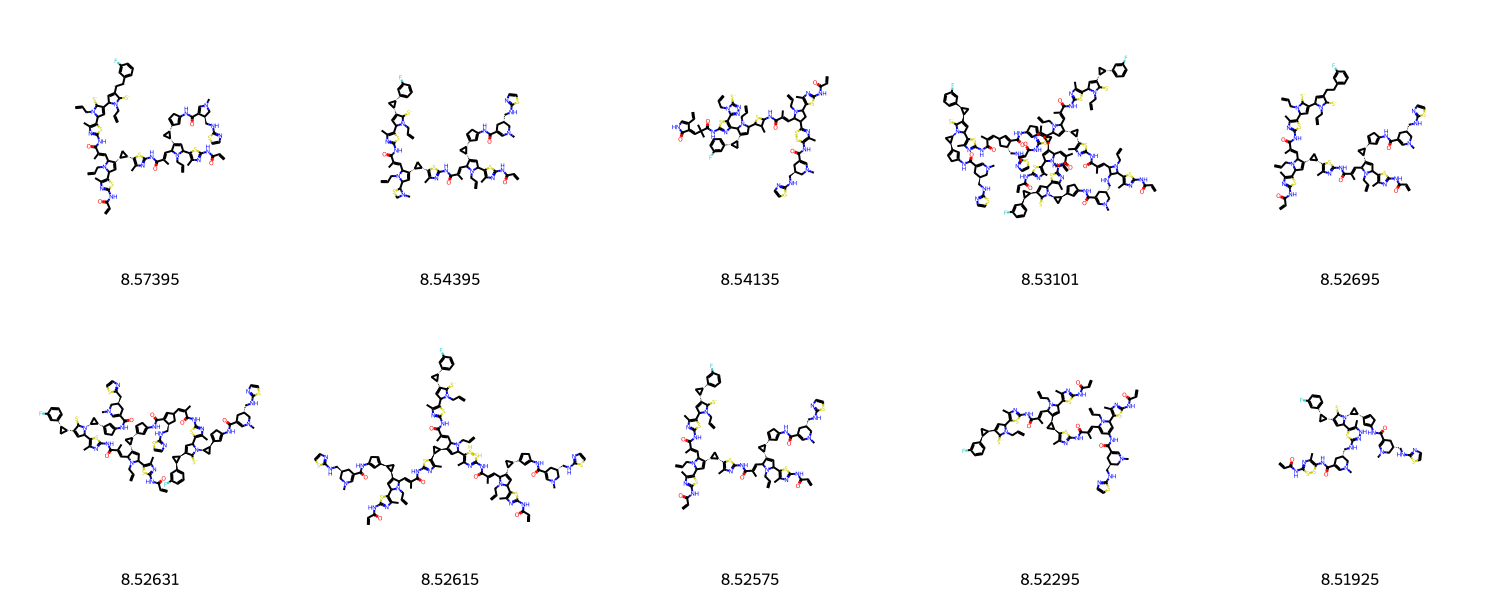

In [25]:
top_n_molecs = [Chem.MolFromSmiles(smiles[1]) for smiles in list(sorted(ga_results.population,reverse=True)[:10])]
top_n_scores = [str(round(smiles[0],5)) for smiles in list(sorted(ga_results.population,reverse=True)[:10])]

img = Draw.MolsToGridImage(top_n_molecs, molsPerRow=5, subImgSize=(300, 300), legends=top_n_scores)
img